In [50]:
from dengo.chemical_network import ChemicalNetwork, reaction_registry, cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import numpy as np
import matplotlib.pyplot as plt
import sympy
import matplotlib

In [51]:
dengo.primordial_rates.setup_primordial();

In [52]:
primordial = ChemicalNetwork()

In [53]:
for i in range(23):
    n = "k%02i" % (i+1)
    if n in reaction_registry:
        primordial.add_reaction(n)

In [54]:
# Initializing primordial network
NCELLS = 1
density = 1e7
temperature = np.logspace(2, 4, NCELLS)
temperature[:] = 2e3
X = 0.5

primordial.init_temperature((1e0, 1e8))

init_array = np.ones(NCELLS) * density
init_values = dict()
init_values['H_1']   = init_array * 0
init_values['H_2']   = X * init_array
init_values['H_m0']  = init_array * tiny
init_values['He_1']  = init_array * tiny
init_values['He_2']  = init_array * tiny
init_values['He_3']  = init_array * tiny
init_values['H2_1']  = init_array * tiny
init_values['H2_2']  = init_array * tiny
init_values['de']    = init_array * 0.0

total_density = primordial.calculate_total_density(init_values)
init_values["H_1"] = init_array.copy() - total_density
init_values = primordial.convert_to_mass_density(init_values)
init_values['de'] = primordial.calculate_free_electrons(init_values)
init_values['density'] = primordial.calculate_total_density(init_values)
number_density = primordial.calculate_number_density(init_values)

# set up initial temperatures values used to define ge
init_values['T'] = temperature

# calculate ge (very crudely, no H2 help here)
gamma = 5.0/3.0
init_values['ge'] = ((temperature * number_density * kboltz)
                     / (init_values['density'] * mh * (gamma - 1)))

In [55]:
# this gives you the rhs function of that particular species
# in this case, its H2_1, molecular H2
# f_H2 is an sympy object!
f_H2 = primordial.species_total('H2_1')

# d f_H2 / d H_2 the jacobian component
dfH2_dH2 = f_H2.diff('H2_1')
dfH2_dH2

-k11[i]*H_2 - k12[i]*de - k13[i]*H_1 + k21[i]*H_1**2 - 2*k23[i]*H2_1

In [56]:
rxn_rates = sorted(primordial.reactions.keys())
species = sorted(primordial.species_list())

In [57]:
# The following gives the array of k01 rates at the temperatures
k01 = primordial.reactions['k01']
k01.coeff_fn(primordial)

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         9.17839771e-09,   9.10254611e-09,   9.02719165e-09])

In [58]:
def get_jac_component(species1, species2):
    f_species1 = primordial.species_total(species1)
    df1_f2 = f_species1.diff(species2)
    return df1_f2

In [59]:
# These are the arguments to the functions of the jacobian that can compute the numerical
# values of each jacobian component
species+rxn_rates+["i"]

['H2_1',
 'H2_2',
 'H_1',
 'H_2',
 'H_m0',
 'He_1',
 'He_2',
 'He_3',
 'de',
 'ge',
 'k01',
 'k02',
 'k03',
 'k04',
 'k05',
 'k06',
 'k07',
 'k08',
 'k09',
 'k10',
 'k11',
 'k12',
 'k13',
 'k14',
 'k15',
 'k16',
 'k17',
 'k18',
 'k19',
 'k21',
 'k22',
 'k23',
 'i']

In [60]:
# rxn_jac is the matrix of functions for the jacobian terms
# species_rates_list is a list of species values and list of rxn_rate arrays
# temp index is the index for the rxn_rate arrays corresponding to a specific temperature
def compute_jacobian(rxn_jac,species_rates_list,temp_index):
    jac = np.zeros((len(rxn_jac),len(rxn_jac)),dtype=float)
    for j in range(len(jac)):
        for k in range(len(jac)):
            jac[j][k] = rxn_jac[j][k](*species_rates_list,i=temp_index)
    return jac

In [61]:
# compute jacobian
rxn_rates = sorted(primordial.reactions.keys())
species = sorted(primordial.species_list())
f_arguments = species+rxn_rates+['i']
rxn_jac = np.zeros((len(species),len(species)),dtype=object)
for j in range(len(species)):
    for k in range(len(species)):
        jac_fn = get_jac_component(species[j],species[k])
        rxn_jac[j][k] = sympy.lambdify(f_arguments,jac_fn,"numpy")

species_values = []
for s in species:
    species_values.append(init_values[s])
rate_arrays = []
for k in range(len(rxn_rates)):
    rate = primordial.reactions[rxn_rates[k]]
    rate_arrays.append(rate.coeff_fn(primordial))

jac_argument = species_values+rate_arrays

In [64]:
#following functions taken from: https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        fig, ax = plt.subplots(figsize=(20, 10), dpi=80)

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

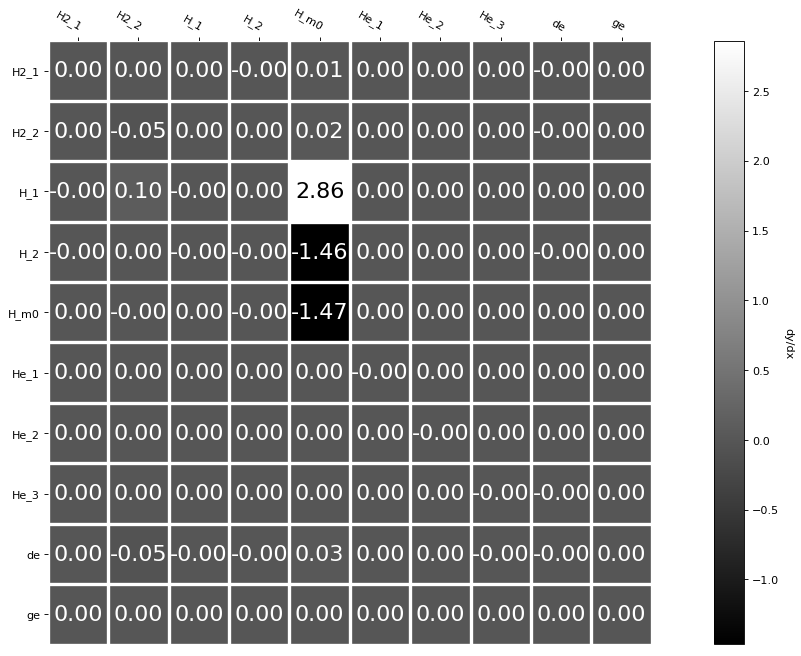

In [82]:
curr_jac = compute_jacobian(rxn_jac,jac_argument,100)

im, cbar = heatmap(curr_jac,species,species, ax=None,
                   cmap="gray", cbarlabel="dy/dx")
texts = annotate_heatmap(im,textcolors=["white","black"],size=20)

fig.tight_layout()
plt.show()